#**WhatsApp Ads Experiment for Six Squad**
## **Measuring the Effectiveness of WhatsApp Business Ads for high-end Streetwear**

### **Group 18 - Madhumitha Sriram, Fahad Alsubaie, Raiymbek Ordabayev, Olimpia Borgohain, Rohit Devanaboina**



## **Pre-Experiment Code**


In [ ]:
## Rough ex-ante Power Calculations

from pingouin import power_ttest
import numpy as np
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

# Reading Loyalty Member CSV
clients = pd.read_csv('/content/drive/MyDrive/830/ClientsData-1.csv', delimiter=';')

# Finding Cohen's D for 80% power
effect_size = power_ttest(power=0.8, n=516, alpha = .05, alternative='two-sided')
print(f" The Cohen's D of outcome variable must be >= {effect_size:.4f} in order to have 80% power")
# Finding Power for small effect_size (0.1)
power = power_ttest(d=0.1 , n=516, alpha = .05, alternative='two-sided')
print(f"With a small effect (d=0.1) we will have a power of {power*100:.2f} %")


# Approximating  required mean difference in outcome, based on effect_size and outcome standard deviation

ctr_std = ((((1-0.04)**2)*0.04*516 + ((0-0.04)**2)*((1-0.04)*516))/516) # Current CTR is ~2.5%
sales_std = np.std(clients['TotalSumOfPurchases'])
prop_std = np.std(clients['NumberOfTransactions']>0)



# Click Through Rate
# mean1 = 0.025 # Current Click Through Rate is ~2.5%
#mean2 = 0.068   # Required CTR
# s1 = ((((1-mean1)**2)*mean1*516 + ((0-mean1)**2)*(100-(mean1*516)))/516)
#s2 = ((((1-mean1)**2)*mean2*516 + ((0-mean2)**2)*(100-(mean2*516)))/516)
#n1 = 516
#n2 = 516

#pooled_std = (((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))**(.5)

# CTR
print('Outcome: Click Through Rate')
print(f'There must be a {effect_size*(ctr_std**0.5)*100:.2f}% increase in CTR to achieve 80% power')
print(f"At a small treatment effect on CTR  - {0.1*(ctr_std**0.5)*100:.2f}% (d = 0.1) - the power is {power*100:.2f}%")

# Sales
print('Outcome: Sales')
print(f'There must be a KZT {effect_size*sales_std:.0f} increase in sales to achieve 80% power')
print(f"At a small treatment effect on Sales  - KZT {0.1*sales_std:.0f} (d = 0.1) - the power is {power*100:.2f}%")

# Purchase Propensity
print('Outcome: Purchase Propensity')
print(f'There must be a {effect_size*prop_std*100:.2f}% increase in purchase propensity to achieve 80% power')
print(f"At a small Purchase Propensity treatment effect - {0.1*prop_std*100:.2f}% (d = 0.1), the power is {power*100:.2f}%")


0.390625

In [ ]:

## Randomization

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

# Reading Loyalty Member CSV
clients = pd.read_csv('/content/drive/MyDrive/830/ClientsData-1.csv', delimiter=';')

# Separating Active members (>0 transactions) from inactive members (0 transactions), for Blocking
cli_0 = clients[clients.NumberOfTransactions == 0]
cli_1 = clients[clients.NumberOfTransactions > 0]

# Sampling 100% of each semgment without replacement (Complete Randmization)
s = 0
clients_0_randomized = cli_0.sample(frac=1, random_state=s).reset_index().drop("index", axis=1)
clients_1_randomized = cli_1.sample(frac=1, random_state=s).reset_index().drop("index", axis=1)

# Assigning Arm to Inactive members - 33% each arm
clients_0_randomized.loc[0:207, "treatment_group"] = 1
clients_0_randomized.loc[0:207, "treatment_label"] = "no message"
clients_0_randomized.loc[208:415, "treatment_group"] = 2
clients_0_randomized.loc[208:415, "treatment_label"] = "message 1"
clients_0_randomized.loc[416:625, "treatment_group"] = 3
clients_0_randomized.loc[416:625, "treatment_label"] = "message 2"

# Assigning Arm to Active members - 33% each arm
clients_1_randomized.loc[0:307, "treatment_group"] = 1
clients_1_randomized.loc[0:307, "treatment_label"] = "no message"
clients_1_randomized.loc[308:615, "treatment_group"] = 2
clients_1_randomized.loc[308:615, "treatment_label"] = "message 1"
clients_1_randomized.loc[616:925, "treatment_group"] = 3
clients_1_randomized.loc[616:925, "treatment_label"] = "message 2"

# Combining Active and Inactive members
clients_randomized = pd.concat([clients_1_randomized,clients_0_randomized],ignore_index=1)

# Using T-Test to verify blocking
from scipy.stats import ttest_ind

t, p = ttest_ind(clients_randomized[clients_randomized.treatment_group==3]['NumberOfTransactions'],clients_randomized[clients_randomized.treatment_group==1]['NumberOfTransactions'], equal_var=0)
print(p > 0.05)

# Exporting Client list with Treatment Assignments

clients_randomized.to_csv("clients_assigned.csv",sep=',')


## **Results**

Now, let us see the results of our experiment. The primary focus of our results are regression test and heterogeneneous treatment effects.   But first, let us explore our dataset.

In [ ]:
!pip install pingouin
!pip install stargazer

In [1]:
# Importing experiment data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

# 7 Days Loyalty Members data
data = pd.read_csv('/content/drive/MyDrive/830/ExperimentDataSunday.csv', delimiter=';')

# Experiment Members
clients_assigned = pd.read_csv('/content/drive/MyDrive/830/clients_assigned.csv', delimiter=',').drop('Unnamed: 0', axis=1).drop(['PartnerName', 'BOTID'],axis=1)

# Aggregating and merging datasets
data = data.groupby('CustomerID').agg({"CheckID":lambda x: x.nunique(), 'Quantity':'sum', 'Summ':'sum', 'AdvertisedProduct':'sum'}).reset_index()
data['Purchase Propensity (post)'] = (data['CheckID'] > 0).astype('int')
data = data.rename(columns={'CheckID':'Total Transactions (post)', 'Summ':'Net Sales (post)', 'AdvertisedProduct':'Total Conversions (post)', "Quantity":'Quantity (post)'})

clients_assigned = clients_assigned.rename(columns={'NumberOfTransactions':'Total Transactions (past)','TotalSumOfPurchases':'Net Sales (past)', 'treatment_group':'Treatment Group'})\
                    .drop('treatment_label', axis=1)

merged = pd.merge(clients_assigned, data, how = 'left', left_on='PartnerID', right_on = 'CustomerID').drop('CustomerID', axis=1).fillna(0)
print(f"Total Customers in experiment who made atleast one purchase = {(merged['Total Transactions (post)'] > 0).sum()}")

# DF without the outlier member
merged_tatiana = merged[merged.PartnerID != "B6E2EB7304FAA17411EE97F302CDE61E"]

# Display Summary Statistics
print('Outlier Member (Tatiana)')
display(merged[merged.PartnerID == "B6E2EB7304FAA17411EE97F302CDE61E"])
print('Mean Outcome Values by Treatment Arm (With Tatiana)')
display(merged.groupby('Treatment Group').agg("mean"))
print('Mean Outcome Values by Treatment Arm (Without Tatiana)')
display(merged_tatiana.groupby('Treatment Group').agg("mean"))



Mounted at /content/drive
Total Customers in experiment who made atleast one purchase = 14
Outlier Member (Tatiana)


,PartnerID,DateOfReg,DateOfBirthday,Total Transactions (past),Net Sales (past),Treatment Group,Total Transactions (post),Quantity (post),Net Sales (post),Total Conversions (post),Purchase Propensity (post)
69,B6E2EB7304FAA17411EE97F302CDE61E,2023-12-11 00:00:00,1979-01-08 00:00:00,2,375000.0,1.0,1.0,9.0,674000.0,0.0,1.0


Mean Outcome Values by Treatment Arm (With Tatiana)


<ipython-input-1-bd5443283373>:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(merged.groupby('Treatment Group').agg("mean"))


,Total Transactions (past),Net Sales (past),Total Transactions (post),Quantity (post),Net Sales (post),Total Conversions (post),Purchase Propensity (post)
Treatment Group,,,,,,,
1.0,0.854651,92977.262151,0.007752,0.027132,1671.957364,0.0,0.007752
2.0,0.812016,89585.616279,0.007752,0.019380,1147.286822,0.0,0.005814
3.0,0.835590,89262.893617,0.015474,0.023211,1928.487427,0.0,0.013540


Mean Outcome Values by Treatment Arm (Without Tatiana)


<ipython-input-1-bd5443283373>:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(merged_tatiana.groupby('Treatment Group').agg("mean"))


,Total Transactions (past),Net Sales (past),Total Transactions (post),Quantity (post),Net Sales (post),Total Conversions (post),Purchase Propensity (post)
Treatment Group,,,,,,,
1.0,0.852427,92429.645184,0.005825,0.009709,366.466019,0.0,0.005825
2.0,0.812016,89585.616279,0.007752,0.019380,1147.286822,0.0,0.005814
3.0,0.835590,89262.893617,0.015474,0.023211,1928.487427,0.0,0.013540


### **EDA**

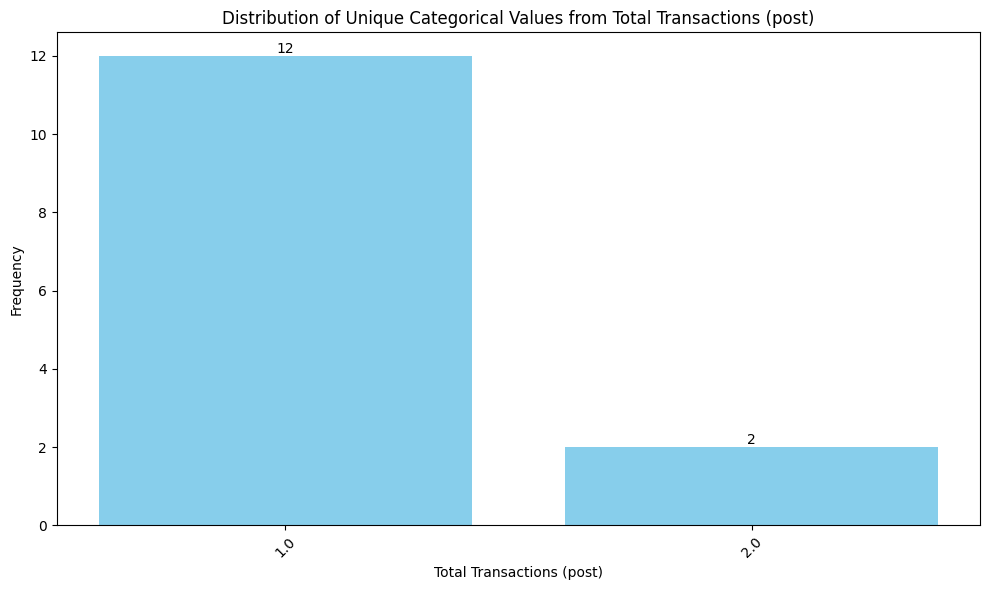

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged' DataFrame is already loaded with your data

# Count the frequency of unique categorical values in the 'Total Transactions (post)' column
value_counts = merged['Total Transactions (post)'].value_counts()

# Sort the value_counts Series by index in ascending order
value_counts_sorted = value_counts.sort_index()

# Remove the value '0' from the index
value_counts_sorted = value_counts_sorted[value_counts_sorted.index != 0]

# Plotting the distribution of unique categorical values
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts_sorted.index.astype(str), value_counts_sorted.values, color='skyblue')

# Adding numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Distribution of Unique Categorical Values from Total Transactions (post)')
plt.xlabel('Total Transactions (post)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-3-da12ca1fca3d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_1['Treatment Group'] = merged_1['Treatment Group'].astype('str').map({'1.0':'Control (No Ad)', '2.0':'Treatment Arm 1 - Standard Ad','3.0':'Treatment Arm 2 - Nudge  Ad' })


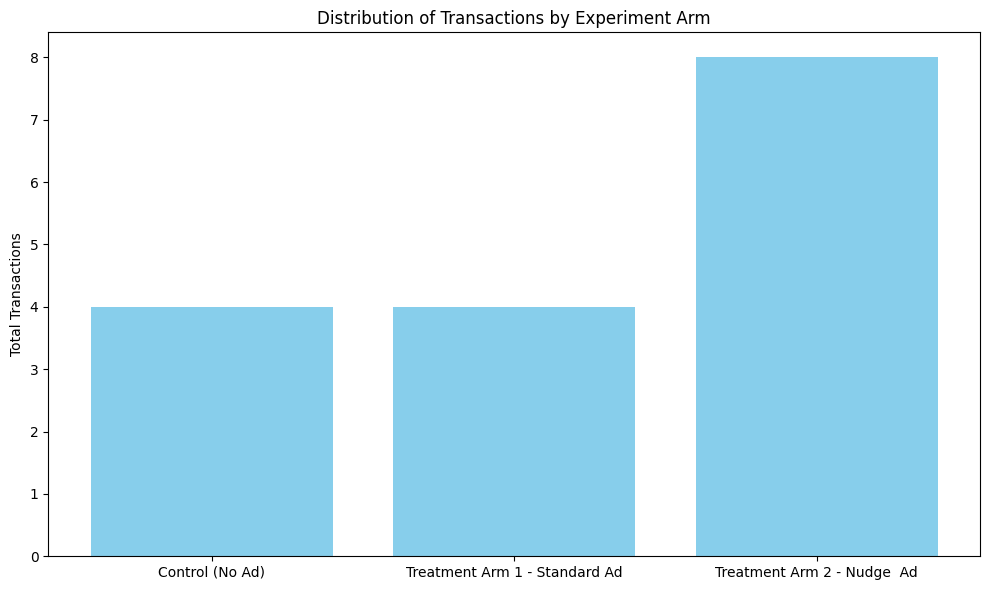

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter only members who made transactons
merged_1 = merged[merged['Purchase Propensity (post)'] > 0]
merged_1['Treatment Group'] = merged_1['Treatment Group'].astype('str').map({'1.0':'Control (No Ad)', '2.0':'Treatment Arm 1 - Standard Ad','3.0':'Treatment Arm 2 - Nudge  Ad' })
merged_df = merged_1.groupby('Treatment Group').agg({'Total Transactions (post)':'sum'}).reset_index()
# Plotting the distribution of unique categorical values
plt.figure(figsize=(10, 6))
bars = plt.bar(merged_df['Treatment Group'],merged_df['Total Transactions (post)'], color='skyblue')

plt.title('Distribution of Transactions by Experiment Arm')
plt.ylabel('Total Transactions')

plt.tight_layout()
plt.show()


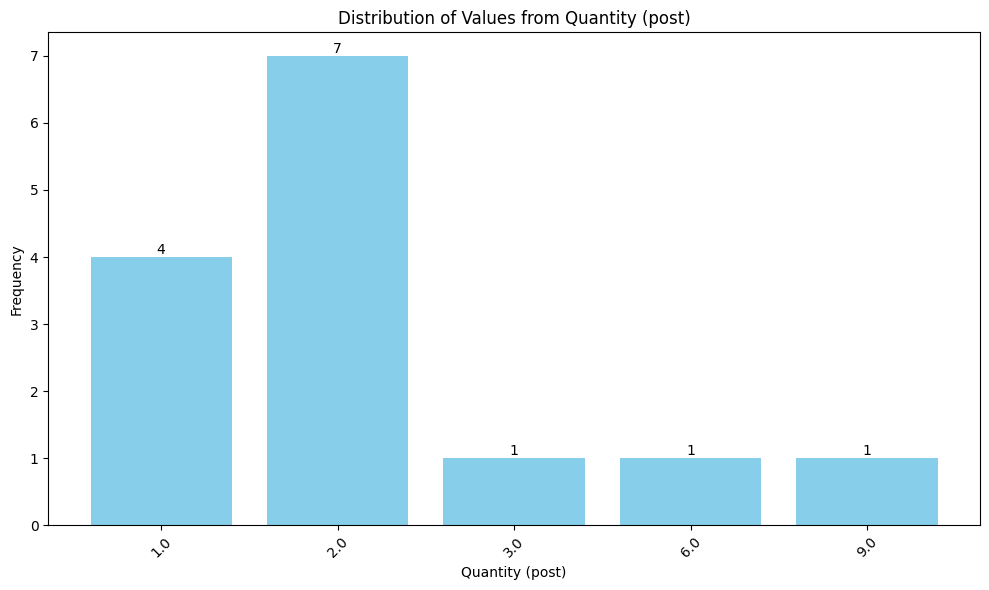

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged' DataFrame is already loaded with your data

# Count the frequency of unique categorical values in the 'Total Transactions (post)' column
value_counts = merged['Quantity (post)'].value_counts()

# Sort the value_counts Series by index in ascending order
value_counts_sorted = value_counts.sort_index()

# Remove the value '0' from the index
value_counts_sorted = value_counts_sorted[value_counts_sorted.index != 0]

# Plotting the distribution of unique categorical values
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts_sorted.index.astype(str), value_counts_sorted.values, color='skyblue')

# Adding numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Distribution of Values from Quantity (post)')
plt.xlabel('Quantity (post)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


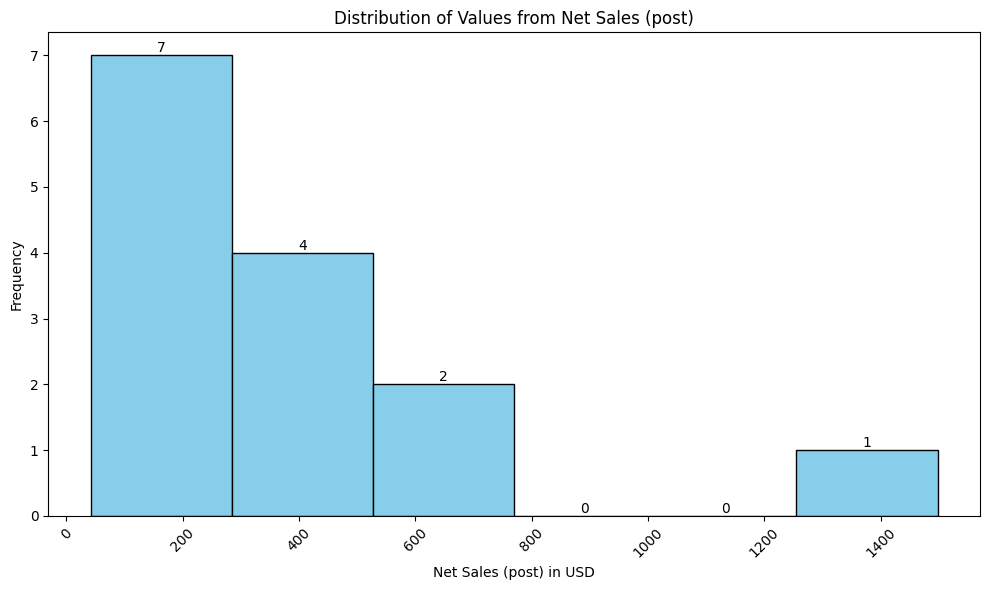

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged' DataFrame is already loaded with your data

# Selecting data from the 'Net Sales (post)' column and removing the value '0'
net_sales_post = merged['Net Sales (post)'][merged['Net Sales (post)'] != 0]

# Plotting the histogram of 'Net Sales (post)'
plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(net_sales_post/450, bins=6, color='skyblue', edgecolor='black')

# Adding data labels on top of each bar
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], int(hist[i]),
             ha='center', va='bottom')

# Adding labels and title
plt.title('Distribution of Values from Net Sales (post)')
plt.xlabel('Net Sales (post) in USD')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Displaying the histogram
plt.tight_layout()
plt.show()


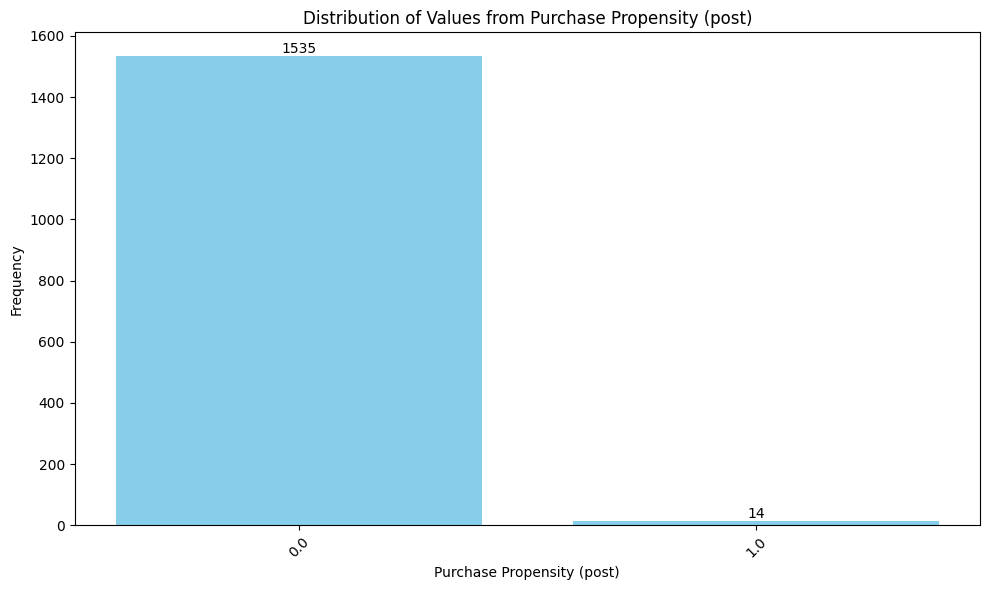

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged' DataFrame is already loaded with your data

# Count the frequency of unique categorical values in the 'Total Transactions (post)' column
value_counts = merged['Purchase Propensity (post)'].value_counts()

# Sort the value_counts Series by index in ascending order
value_counts_sorted = value_counts.sort_index()

# Remove the value '0' from the index
value_counts_sorted = value_counts_sorted[value_counts_sorted.index]

# Plotting the distribution of unique categorical values
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts_sorted.index.astype(str), value_counts_sorted.values, color='skyblue')

# Adding numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Distribution of Values from Purchase Propensity (post)')
plt.xlabel('Purchase Propensity (post)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Proportions Test:**
We applied a statistical test to check if the proportion of randomization are as intended. By calculating and comparing the proportions of each treatment groups and Control group against their observed proportions within the total sample, we can verify the effectiveness of the randomization process.

In [8]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Total Participants
n = len(merged['Treatment Group'])

# Arms
n_treated = np.sum(merged['Treatment Group'] == 1) # Control Group
_, p_val = proportions_ztest(n_treated, n, value = n_treated/n)
print(f"The p-value for the proportions test is {p_val:.2} so we fail to reject the null hypothesis of proper randomization")

n_treated = np.sum(merged['Treatment Group'] == 2) # Treatment 1 - Standard Ad
_, p_val = proportions_ztest(n_treated, n, value = n_treated/n)
print(f"The p-value for the proportions test is {p_val:.2} so we fail to reject the null hypothesis of proper randomization")

n_treated = np.sum(merged['Treatment Group'] == 3) # Treatment 2 - Nudge Ad
_, p_val = proportions_ztest(n_treated, n, value = n_treated/n)
print(f"The p-value for the proportions test is {p_val:.2} so we fail to reject the null hypothesis of proper randomization")

The p-value for the proportions test is 1.0 so we fail to reject the null hypothesis of proper randomization
The p-value for the proportions test is 1.0 so we fail to reject the null hypothesis of proper randomization
The p-value for the proportions test is 1.0 so we fail to reject the null hypothesis of proper randomization


Summary: The result of the proportions z-tests, with a p-value of 1.0, indicate that there is no statistical evidence to reject the null hypothesis, which means that the randomization was done properly.They have been divided into 3 equal arms as intended (516 obs vs 516 obs vs 517 obs).

### **Balance Checks:**
We have two key metrics for which we would like a balance between the 3 arms: Total Transactions (past) and Net Sales (past).

By using t-test we will be able to compare the means of Total Transactions and Net Sales between each pair of treatment arms and control group. (Group 1 vs. Group 2, Group 1 vs. Group 3, and Group 2 vs. Group 3). This choice of test will help us to check whether any significant differences exist between groups that could influence the results beyond the treatment effects.

In [ ]:
from scipy.stats import ttest_ind

# Dividing by Arm and by variable
group1_transactions = merged[merged['Treatment Group'] == 1]['Total Transactions (past)']
group1_sales = merged[merged['Treatment Group'] == 1]['Net Sales (past)']

group2_transactions = merged[merged['Treatment Group'] == 2]['Total Transactions (past)']
group2_sales = merged[merged['Treatment Group'] == 2]['Net Sales (past)']

group3_transactions = merged[merged['Treatment Group'] == 3]['Total Transactions (past)']
group3_sales = merged[merged['Treatment Group'] == 3]['Net Sales (past)']

# T Tests
t_stat_transactions_12, p_val_transactions_12 = ttest_ind(group1_transactions, group2_transactions, equal_var=0)
print(f"Group 1 vs Group 2 - Total Transactions (past): t-stat = {t_stat_transactions_12:.2f}, p-value = {p_val_transactions_12:.3f}")

t_stat_sales_12, p_val_sales_12 = ttest_ind(group1_sales, group2_sales, equal_var=0)
print(f"Group 1 vs Group 2 - Net Sales (past): t-stat = {t_stat_sales_12:.2f}, p-value = {p_val_sales_12:.3f}")

t_stat_transactions_13, p_val_transactions_13 = ttest_ind(group1_transactions, group3_transactions, equal_var=0)
print(f"Group 1 vs Group 3 - Total Transactions (past): t-stat = {t_stat_transactions_13:.2f}, p-value = {p_val_transactions_13:.3f}")

t_stat_sales_13, p_val_sales_13 = ttest_ind(group1_sales, group3_sales, equal_var=0)
print(f"Group 1 vs Group 3 - Net Sales (past): t-stat = {t_stat_sales_13:.2f}, p-value = {p_val_sales_13:.3f}")

t_stat_transactions_23, p_val_transactions_23 = ttest_ind(group2_transactions, group3_transactions, equal_var=0)
print(f"Group 2 vs Group 3 - Total Transactions (past): t-stat = {t_stat_transactions_23:.2f}, p-value = {p_val_transactions_23:.3f}")

t_stat_sales_23, p_val_sales_23 = ttest_ind(group2_sales, group3_sales, equal_var=0)
print(f"Group 2 vs Group 3 - Net Sales (past): t-stat = {t_stat_sales_23:.2f}, p-value = {p_val_sales_23:.3f}")

Group 1 vs Group 2 - Total Transactions (past): t-stat = 0.65, p-value = 0.513
Group 1 vs Group 2 - Net Sales (past): t-stat = 0.34, p-value = 0.737
Group 1 vs Group 3 - Total Transactions (past): t-stat = 0.29, p-value = 0.773
Group 1 vs Group 3 - Net Sales (past): t-stat = 0.41, p-value = 0.680
Group 2 vs Group 3 - Total Transactions (past): t-stat = -0.36, p-value = 0.720
Group 2 vs Group 3 - Net Sales (past): t-stat = 0.04, p-value = 0.972


Summary: The t-test results for all comparisons between the treatment groups in "Total Transactions (past)" and "Net Sales (past)" show no statistically significant differences in means.:

* All p-values are all above 0.05. this tell us that there is no strong evidence to suggest that the treatment groups differ in terms of past total transactions or net sales.

* The t-statistics range from -0.36 to 0.65 for "Total Transactions (past)" and from 0.04 to 0.41 for "Net Sales (past)", further indicating that the differences between group means are very minimal and not statistically significant.

Overall, these findings indicates that the treatment groups are balanced with respect to "Total Transactions (past)" and "Net Sales (past)" before the treatment application.

### **Regression Tests**

####**Click Through Rate**

In [9]:
!pip install stargazer

In [10]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

merged_12 = merged.loc[:]
merged_12 = merged_12[merged_12 ['Treatment Group'] != 1.0]
merged_12['Treatment Group'] = merged_12 ['Treatment Group'] > 2
merged_12['click'] = 0
merged_12.iloc[0:21,-1] = 1 # 21 clicks,
merged_12.iloc[-28:,-1] = 1 # 28 clicks

ctr = smf.ols('click ~ Q("Treatment Group")', data= merged_12).fit(cov_type = 'HC1')

summary_c1 = Stargazer([ctr])

summary_c1.title('Click Rate - Standard Ad vs Nudge Ad')
summary_c1.custom_columns(['Click Rate'])
summary_c1.significant_digits(2)
summary_c1.rename_covariates({'Q("Treatment Group")[T.True]': 'Treatment Effect'})
summary_c1.show_confidence_intervals(True)
summary_c1.show_degrees_of_freedom(False)
summary_c1.show_r2 = False
summary_c1.show_adj_r2 = False
summary_c1.show_residual_std_err = False
summary_c1.show_f_statistic = False
summary_c1.show_model_numbers(False)
summary_c1


Summary: The nudge treatment does not have a significant effect on the Click Rate vs the Standard Ad.

####**Conversions**

In [11]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

merged_c1 = merged.loc[:]
merged_c1 = merged_c1[merged_c1['Treatment Group'] != 3.0]
merged_c1['Treatment Group'] = merged_c1['Treatment Group'] >1

merged_12 = merged.loc[:]
merged_12 = merged_12[merged_12 ['Treatment Group'] != 1.0]
merged_12['Treatment Group'] = merged_12 ['Treatment Group'] > 2

conversions_c1 = smf.ols('Q("Total Conversions (post)") ~ Q("Treatment Group")', data= merged_c1).fit(cov_type = 'HC1')
conversions_12 = smf.ols('Q("Total Conversions (post)") ~ Q("Treatment Group")', data= merged_12).fit(cov_type = 'HC1')

summary_c1 = Stargazer([conversions_c1,conversions_12])


summary_c1.title('Treatment Effect - Conversions')
summary_c1.custom_columns(['Control vs Standard Ad', 'Standard vs Nudge'])
summary_c1.significant_digits(2)
summary_c1.rename_covariates({'Q("Treatment Group")[T.True]': 'Treatment Effect'})
summary_c1.show_confidence_intervals(False)
summary_c1.show_degrees_of_freedom(False)
summary_c1.show_r2 = False
summary_c1.show_adj_r2 = False
summary_c1.show_residual_std_err = False
summary_c1.show_f_statistic = False
summary_c1.show_model_numbers(True)
summary_c1

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1925: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/

Summary: Since none of the customers in any of the arms purchased the advertised product, we will drop this outcome from the rest of our analysis.

####**Rest of the Outcomes:**

Now, let us look at the treatment effect for the control group and treatment arm 1 all the members.

In [12]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

# for Control group and treatment 1
merged_control = merged.loc[:]

merged_control = merged_control[merged_control['Treatment Group'] != 3.0]
merged_control['Treatment Group'] = merged_control['Treatment Group'] > 1

transaction_c1 = smf.ols('Q("Total Transactions (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
quantity_c1 = smf.ols('Q("Quantity (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
sales_c1 = smf.ols('Q("Net Sales (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
propensity_c1 = smf.ols('Q("Purchase Propensity (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
summary_c1 = Stargazer([transaction_c1, quantity_c1, sales_c1, propensity_c1])

summary_c1.title('Treatment Effects - Control vs Status Quo Ad')
summary_c1.custom_columns(['Total Transactions', 'Quantity',
                           'Net Sales', 'Purchase Propensity'])
summary_c1.significant_digits(2)
summary_c1.rename_covariates({'Q("Treatment Group")[T.True]': 'Treatment Effect', 'Q("Total Transactions (past)")': 'Past Transactions', 'Q("Net Sales (past)")':'Past Net Sales'})
summary_c1.covariate_order(['Q("Treatment Group")[T.True]','Q("Total Transactions (past)")', 'Q("Net Sales (past)")'])
summary_c1.show_confidence_intervals(False)
summary_c1.show_degrees_of_freedom(False)
summary_c1.show_r2 = False
summary_c1.show_adj_r2 = False
summary_c1.show_residual_std_err = False
summary_c1.show_f_statistic = False
summary_c1

The above table presents treatment effects by comparing the control group to the status quo advertising group across various metrics, including Total Transactions, Quantity, Net Sales, and Purchase Propensity.
Treatment effects are expressed in the table, indicating changes in the mentioned metrics due to the advertising treatment. <br>
Notably, there is no statistically significant change in Total Transactions, a slight decrease in Quantity, a significant decrease in Net Sales, and no change in Purchase Propensity.

The "Past Transactions" and "Past Net Sales" sections provide a comparison with historical data, showing a slight increase in past transactions (p=0.01) but no significant change in past net sales.

Now,  we will see the treatment effect for control group and treatment arm 1, but excluding Tatiana ( the one outlier in the control group)

In [13]:
# Control vs Treatment 1 - Without Tatiana

merged_control = merged_tatiana.loc[:]

merged_control = merged_control[merged_control['Treatment Group'] != 3.0]
merged_control['Treatment Group'] = merged_control['Treatment Group'] > 1

transaction_c1 = smf.ols('Q("Total Transactions (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
quantity_c1 = smf.ols('Q("Quantity (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
sales_c1 = smf.ols('Q("Net Sales (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
propensity_c1 = smf.ols('Q("Purchase Propensity (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
summary_c1 = Stargazer([transaction_c1, quantity_c1, sales_c1, propensity_c1])

summary_c1.title('Treatment Effects - Control vs Status Quo Ad (Without Tatiana)')
summary_c1.custom_columns(['Total Transactions', 'Quantity',
                           'Net Sales', 'Purchase Propensity'])
summary_c1.significant_digits(2)
summary_c1.rename_covariates({'Q("Treatment Group")[T.True]': 'Treatment Effect', 'Q("Total Transactions (past)")': 'Past Transactions', 'Q("Net Sales (past)")':'Past Net Sales'})
summary_c1.covariate_order(['Q("Treatment Group")[T.True]','Q("Total Transactions (past)")', 'Q("Net Sales (past)")'])
summary_c1.show_confidence_intervals(False)
summary_c1.show_degrees_of_freedom(False)
summary_c1.show_r2 = False
summary_c1.show_adj_r2 = False
summary_c1.show_residual_std_err = False
summary_c1.show_f_statistic = False
summary_c1

Similar to the previous table, we have kept the same key metrics under consideration, comparing the effects of treatment arm 1 against a control group. However, excludeing one person named Tatiana (outlier).
<br>
**Treatment Effect:**
A value of 0.00 for Total Transactions suggests no significant change in the total number of transactions.
An increase of 0.01 in Quantity implies a small positive impact on the quantity of items sold.
A substantial increase of 796.13 in Net Sales indicates a significant positive impact on the overall sales revenue.
A negligible change of 0.00 in Purchase Propensity suggests minimal impact on the likelihood of making a purchase.<br>
The rows labeled "Past Transactions" and "Past Net Sales" compare the treatment effects to historical data, excluding Tatiana.
An increase of 0.01 in past transactions suggests a slight positive impact on historical transaction numbers.
No significant change is observed in past net sales, as indicated by a value of 0.00.

Now, we will measure the treatment effect for treatment arm 1 and treatment arm 2, for all the members.

In [14]:
# Treatment 1 vs Treatment 2 - All Members

merged_control = merged.loc[:]

merged_control = merged_control[merged_control['Treatment Group'] != 1.0]
merged_control['Treatment Group'] = merged_control['Treatment Group'] > 2

transaction_c1 = smf.ols('Q("Total Transactions (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
quantity_c1 = smf.ols('Q("Quantity (post)") ~ Q("Treatment Group") + Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
sales_c1 = smf.ols('Q("Net Sales (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
propensity_c1 = smf.ols('Q("Purchase Propensity (post)") ~ Q("Treatment Group")+ Q("Total Transactions (past)") + Q("Net Sales (past)")', data= merged_control).fit(cov_type = 'HC1')
summary_c1 = Stargazer([transaction_c1, quantity_c1, sales_c1, propensity_c1])

summary_c1.title('Treatment Effects - Status Quo Ad vs Nudge Ad')
summary_c1.custom_columns(['Total Transactions', 'Quantity',
                           'Net Sales', 'Purchase Propensity'])
summary_c1.significant_digits(2)
summary_c1.rename_covariates({'Q("Treatment Group")[T.True]': 'Treatment Effect', 'Q("Total Transactions (past)")': 'Past Transactions', 'Q("Net Sales (past)")':'Past Net Sales'})
summary_c1.covariate_order(['Q("Treatment Group")[T.True]','Q("Total Transactions (past)")', 'Q("Net Sales (past)")'])
summary_c1.show_confidence_intervals(False)
summary_c1.show_degrees_of_freedom(False)
summary_c1.show_r2 = False
summary_c1.show_adj_r2 = False
summary_c1.show_residual_std_err = False
summary_c1.show_f_statistic = False
summary_c1

Once again, after having the same key metrics, we will compare the treatment effect between the "Status Quo Ad" and the "Nudge Ad."<br>
**Treatment Effect:**
WE can see a positive treatment effect of 0.01 for Total Transactions suggesting a slight increase in the total number of transactions with the Nudge Ad.
No significant change in Quantity (0.00) indicates little impact on the quantity of items sold.
A substantial increase of 795.38 in Net Sales suggests a significant positive impact on the overall sales revenue with the Nudge Ad.
A positive treatment effect of 0.01 in Purchase Propensity indicates a slight increase in the likelihood of making a purchase with the Nudge Ad.
<br>
**Past Transactions, Past Net Sales:**
A positive treatment effect of 0.01 in past transactions suggests a slight increase in historical transaction numbers with the Nudge Ad.
A decrease of -0.01 in past Quantity implies a small reduction in the quantity of items sold.
A significant decrease of -518.79 in past Net Sales indicates a negative impact on historical sales revenue with the Nudge Ad.

###**Heterogeneous Treatment Effects**

In [16]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')


# 7 Days Loyalty Member Sales

data = pd.read_csv('/content/drive/MyDrive/830/ExperimentDataSunday.csv',
                   delimiter=';')
clients = pd.read_csv('/content/drive/MyDrive/830/ClientsData-1.csv',
                      delimiter=';')
assignments = pd.read_csv('/content/drive/MyDrive/830/clients_assigned.csv',
                          delimiter=',').drop('Unnamed: 0', axis=1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data = data.groupby('CustomerID').agg({"CheckID":lambda x: x.nunique(), 'Quantity':'sum', 'Summ':'sum'}).reset_index()
data['CheckID'] = (data['CheckID'] > 0).astype('int')
data = data.rename(columns={'CheckID':'propensity'})
clients = clients.drop(['BOTID'],axis=1) #'PartnerName','DateOfReg',
merged = clients.merge(data, how='left', left_on="PartnerID", right_on = 'CustomerID').fillna(0).drop('CustomerID',axis=1)

In [18]:
#Heterogeneous Treatment Effect on date of birth
df_ht_dob=merged.copy()
df_ht_dob_srt=df_ht_dob.sort_values(by='DateOfBirthday', ascending=True)
#removing the last rows with DOB >= 2023
df_ht_dob_srt=df_ht_dob_srt.iloc[:1506,:]

df_ht_dob_srt = df_ht_dob_srt.sort_values(by='DateOfReg',ascending=True)
# removing rows with DOR in the year 2001, before store opened
df_ht_dob_srt = df_ht_dob_srt.sort_values(by='DateOfReg',ascending=True).iloc[30:, :]


df_ht_dob_mrg=df_ht_dob_srt.merge(assignments[['PartnerID', 'treatment_group']], how = 'left', on='PartnerID')



In [19]:
# Convert to datetime
df_ht_dob_mrg['DateOfBirthday']=pd.to_datetime(df_ht_dob_mrg['DateOfBirthday'])
df_ht_dob_mrg['DateOfReg']=pd.to_datetime(df_ht_dob_mrg['DateOfReg'])
current_date = pd.to_datetime('2024-02-25')
df_ht_dob_mrg['Age'] = current_date.year - df_ht_dob_mrg['DateOfBirthday'].dt.year
df_ht_dob_mrg['Days_since'] = (current_date - df_ht_dob_mrg['DateOfReg']).dt.days

# Heterogeneous treatment effect of generation
bins=[0,27,43,59]
labels = ['Gen Z', 'Millennials', 'Gen X']

df_ht_dob_mrg['Generation'] = pd.cut(df_ht_dob_mrg['Age'], bins=bins, labels=labels)

# Heterogeneous treatment effect of days since the registered
bins = bins=[0, 100,200,300,318]
labels = ['100', '200', '300', 'DayOne']
df_ht_dob_mrg['Days_since_grp'] = pd.cut(df_ht_dob_mrg['Days_since'], bins=bins, labels=labels).astype('category')

# Drop NA
df_ht_dob_mrg = df_ht_dob_mrg.dropna()

In [20]:
df_ht_dob_mrg.drop(columns=['DateOfBirthday','NumberOfTransactions','PartnerName',
                         'DateOfReg','TotalSumOfPurchases'], inplace=True, axis=1)

<Axes: >

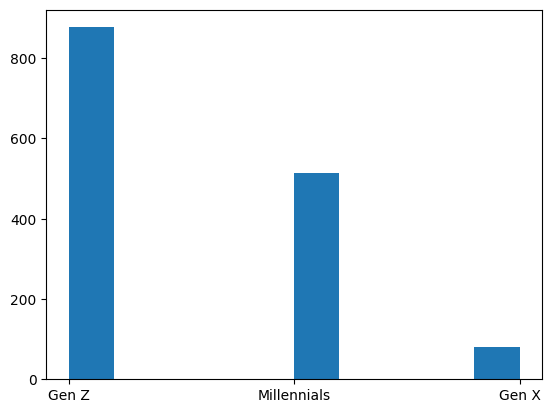

In [21]:
df_ht_dob_mrg['Generation'].hist(grid=False)

<Axes: >

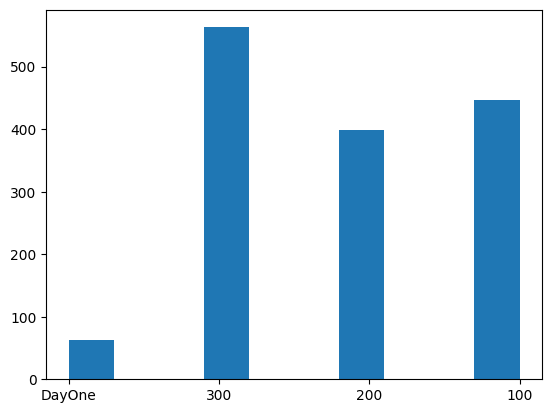

In [22]:
df_ht_dob_mrg['Days_since_grp'].hist(grid=False)

In [23]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

df_ht_dob_mrg_g = df_ht_dob_mrg[df_ht_dob_mrg.Generation != 'Boomer'] # drop boomers, only 5 observations
df_ht_dob_mrg_c1 = df_ht_dob_mrg_g[df_ht_dob_mrg_g.treatment_group != 3.0]
df_ht_dob_mrg_12 = df_ht_dob_mrg_g[df_ht_dob_mrg_g.treatment_group != 1.0]

# Sales - Generation

model_s_c1 = smf.ols('Summ ~ treatment_group : Generation', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_s_12 = smf.ols('Summ ~ treatment_group : Generation', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

# Quantity - Generation
model_q_c1 = smf.ols('Quantity ~ treatment_group : Generation', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_q_12 = smf.ols('Quantity ~ treatment_group : Generation', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

# Propensity - Generation
model_p_c1 = smf.ols('propensity ~ treatment_group : Generation', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_p_12 = smf.ols('propensity ~ treatment_group : Generation', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

stargazer = Stargazer([model_s_c1, model_s_12,model_q_c1, model_q_12,model_p_c1, model_p_12])
stargazer.title('Regression Results : Interaction Effect of Generation and Treatment')
stargazer.custom_columns(['Sales - C vs T1', 'Sales - T1 vs T2','Quantity - C vs T1', 'Quantity - T1 vs T2','Propensity - C vs T1', 'Propensity - T1 vs T2'])
stargazer.significant_digits(2)
stargazer.rename_covariates({'treatment_group:Generation[Gen X]': 'Treatment Effect (GenX)', 'treatment_group:Generation[Gen Z]': 'Treatment Effect (GenZ)',
                             'treatment_group:Generation[Millennials]':'Treatment Effect (Millenials)'})
stargazer.show_confidence_intervals(False)
stargazer.show_degrees_of_freedom(False)
stargazer.show_r2 = False
stargazer.show_adj_r2 = False
stargazer.show_residual_std_err = False
stargazer.show_f_statistic = False
stargazer

In [24]:
# Days since registration

df_ht_dob_mrg_r = df_ht_dob_mrg#[df_ht_dob_mrg.Dats_since_grp != 'DayOne'] # drop DayOne, only ~60 observations
df_ht_dob_mrg_c1 = df_ht_dob_mrg_r[df_ht_dob_mrg.treatment_group != 3.0]
df_ht_dob_mrg_12 = df_ht_dob_mrg_r[df_ht_dob_mrg.treatment_group != 1.0]

# Sales

model_s_c1 = smf.ols('Summ ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_s_12 = smf.ols('Summ ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

# Quantity
model_q_c1 = smf.ols('Quantity ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_q_12 = smf.ols('Quantity ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

# Propensity
model_p_c1 = smf.ols('propensity ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_c1).fit(cov_type='HC1')
model_p_12 = smf.ols('propensity ~ treatment_group : Days_since_grp', data=df_ht_dob_mrg_12).fit(cov_type='HC1')

stargazer = Stargazer([model_s_c1, model_s_12,model_q_c1, model_q_12,model_p_c1, model_p_12])

stargazer.title('Regression Results : Interaction Effect of Days since Registration and Treatment Group')
stargazer.custom_columns(['Sales - C vs T1', 'Sales - T1 vs T2','Quantity - C vs T1', 'Quantity - T1 vs T2','Propensity - C vs T1', 'Propensity - T1 vs T2'])
stargazer.significant_digits(2)
stargazer.rename_covariates({'treatment_group:Days_since_grp[100]': 'Treatment Effect (<100 days)', 'treatment_group:Days_since_grp[200]': 'Treatment Effect (100-200d)',
                             'treatment_group:Days_since_grp[300]':'Treatment Effect (200-300 days)', 'treatment_group:Days_since_grp[DayOne]':'Treatment Effect (Day One Members)'})
stargazer.show_confidence_intervals(False)
stargazer.show_degrees_of_freedom(False)
stargazer.show_r2 = False
stargazer.show_adj_r2 = False
stargazer.show_residual_std_err = False
stargazer.show_f_statistic = False
stargazer



###**Fixed Effects**

In [25]:
!pip install pyfixest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.1 MB/s eta 0:00:00


In [27]:
from pyfixest.estimation import feols
from pyfixest import etable

# Adding day info to data
d_data = pd.read_csv('/content/drive/MyDrive/830/ExperimentDataSunday.csv', delimiter=';')
d_data["day_num"] = pd.to_datetime(d_data["DateAndTime"]).dt.day
d_data["day_of"] = pd.to_datetime(d_data["DateAndTime"]).dt.dayofweek

d_data = d_data.groupby('CustomerID').agg({"CheckID":lambda x: x.nunique(), 'Quantity':'sum', 'Summ':'sum', 'AdvertisedProduct':'sum', "day_num":'mean',"day_of":"mean"}).reset_index()
d_data['propensity'] = (d_data['CheckID'] > 0).astype('int')

d_data = d_data.rename(columns={'CheckID':'transactions'})
clients_assigned = pd.read_csv('/content/drive/MyDrive/830/clients_assigned.csv', delimiter=',').drop('Unnamed: 0', axis=1).drop(['PartnerName', 'BOTID'],axis=1)\
                                                                                              .rename(columns={'NumberOfTransactions':'transactions_past', 'TotalSumOfPurchases':'sales_past'})
clients_assigned['propensity_past'] = clients_assigned.transactions_past > 0
merged_day = pd.merge(clients_assigned, d_data, how = 'left', left_on='PartnerID', right_on = 'CustomerID').drop('CustomerID', axis=1).fillna(0).rename(columns={'Treatment Group':'treatment'})
#merged_day= merged_day[merged_day['PartnerID'] != 'B6E2EB7304FAA17411EE97F302CDE61E'] # w/o tatiana

In [28]:
# for control group and treatment 1
merged_control = merged_day.loc[:]

merged_control = merged_control[merged_control['treatment_group'] != 3.0]
merged_control['treatment_group'] = merged_control['treatment_group'] > 1

transaction_c1 = feols('transactions  ~ treatment_group |  day_of + propensity_past', data= merged_control).vcov('hetero')
quantity_c1 = feols('Quantity  ~ treatment_group |  day_of + propensity_past', data= merged_control).vcov('hetero')
sales_c1 = feols('Summ  ~ treatment_group |  day_of + propensity_past', data= merged_control).vcov('hetero')
propensity_c1 = feols('propensity ~ treatment_group | day_of + propensity_past', data= merged_control).vcov('hetero')
print('Fixed Effects - Control vs Treatment 1')
etable([transaction_c1,quantity_c1, sales_c1, propensity_c1])

Fixed Effects - Control vs Treatment 1
                           est1            est2                 est3            est4
---------------  --------------  --------------  -------------------  --------------
depvar             transactions        Quantity                 Summ      propensity
------------------------------------------------------------------------------------
treatment_group  -0.000 (0.003)  -0.006 (0.019)  -556.843 (1417.712)  -0.000 (0.003)
------------------------------------------------------------------------------------
day_of                        x               x                    x               x
propensity_past               x               x                    x               x
------------------------------------------------------------------------------------
R2                        0.799           0.305                0.113           0.713
S.E. type                hetero          hetero               hetero          hetero
Observations              

In [29]:
# for and treatment 1 and Treatment 2
merged_12 = merged_day.loc[:]

merged_12 = merged_12[merged_12['treatment_group'] != 1.0]
merged_12['treatment_group'] = merged_12['treatment_group'] > 2

transaction_12 = feols('transactions  ~ treatment_group |  day_of + propensity_past', data= merged_12).vcov('hetero')
quantity_12 = feols('Quantity  ~ treatment_group |  day_of + propensity_past', data= merged_12).vcov('hetero')
sales_12 = feols('Summ  ~ treatment_group |  day_of + propensity_past', data= merged_12).vcov('hetero')
propensity_12 = feols('propensity ~ treatment_group | day_of + propensity_past', data= merged_12).vcov('hetero')

print('Fixed Effects - Treatment 1 vs Treatment 2')
etable([transaction_12,quantity_12, sales_12, propensity_12])


Fixed Effects - Treatment 1 vs Treatment 2
                           est1            est2                est3            est4
---------------  --------------  --------------  ------------------  --------------
depvar             transactions        Quantity                Summ      propensity
-----------------------------------------------------------------------------------
treatment_group  -0.005 (0.003)  -0.017 (0.009)  -533.770 (560.994)  -0.002 (0.002)
-----------------------------------------------------------------------------------
day_of                        x               x                   x               x
propensity_past               x               x                   x               x
-----------------------------------------------------------------------------------
R2                        0.895           0.725               0.674           0.899
S.E. type                hetero          hetero              hetero          hetero
Observations               1033  

###**Power Analysis (Fixed Effects Model)**

In [30]:
from statsmodels.stats.power import TTestPower
import numpy as np

####**Control vs Standard Ad**

In [ ]:
# Transactions

group1_2 = merged[merged['Treatment Group']!= 3]
sd=np.std(group1_2['Total Transactions (post)'])
ATE= 0
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.050000000000000065

In [ ]:
group1_2 = merged[merged['Treatment Group']!= 3]
sd=np.std(group1_2['Quantity (post)'])
ATE= -0.006
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.08341599552588469

In [ ]:
group1_2 = merged[merged['Treatment Group']!= 3]
sd=np.std(group1_2['Net Sales (post)'])
ATE= -556.843
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.11513405884752545

In [ ]:
group1_2 = merged[merged['Treatment Group']!= 3]
sd=np.std(group1_2['Purchase Propensity (post)'])
ATE= 0
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.050000000000000065

####**Standard AD vs Nudge AD**

In [ ]:
group2_3 = merged[merged['Treatment Group']!= 1]
sd=np.std(group2_3['Total Transactions (post)'])
ATE= -0.005
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)

0.25342840319668325

In [ ]:
group2_3 = merged[merged['Treatment Group']!= 1]
sd=np.std(group2_3['Quantity (post)'])
ATE= -0.0017
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.055227553013863395

In [ ]:
group2_3 = merged[merged['Treatment Group']!= 1]
sd=np.std(group2_3['Net Sales (post)'])
ATE=  -533.770
TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.1674953593324739

In [ ]:
group2_3 = merged[merged['Treatment Group']!= 1]
sd=np.std(group2_3['Purchase Propensity (post)'])
ATE= -0.002

TTestPower().power(effect_size= ATE/sd, nobs= 1031, alternative='two-sided', alpha=.05)


0.10045603261284239

###**ROI**

In [ ]:
cost_per_ad = 0.0604 * 450 * 1.01

avg_margin = 0.57 # average 57% margin on sales

# Fixed Effects model - Without Tatiana - Standard Ad (Treatment 1)

effect = 755.208
se = 539.417
effect_lower = effect - se*1.96
effect_upper = effect + se*1.96

roi = (effect*avg_margin - cost_per_ad)/cost_per_ad
roi_lower = (effect_lower*avg_margin - cost_per_ad)/cost_per_ad
roi_upper = (effect_upper*avg_margin - cost_per_ad)/cost_per_ad

print(f'Estimated ROIs w/o Tatiana: Estimate - {roi},Lower Bound - {roi_lower}, Upper Bound - {roi_upper}')

# Fixed Effects model - with Tatiana - Standard Ad (Treatment 1)

effect_t = -556.843
se_t = 1417.712
effect_t_lower = effect_t - se_t*1.96
effect_t_upper = effect_t + se_t*1.96

roi_t = (effect_t*avg_margin - cost_per_ad)/cost_per_ad
roi_t_lower = (effect_t_lower*avg_margin - cost_per_ad)/cost_per_ad
roi_t_upper = (effect_t_upper*avg_margin - cost_per_ad)/cost_per_ad

print(f'Estimated ROIs w/ Tatiana: Estimate - {roi_t},Lower Bound - {roi_t_lower}, Upper Bound - {roi_t_upper}')


Estimated ROIs w/o Tatiana: Estimate - 14.68088649924595,Lower Bound - -7.271651126702072, Upper Bound - 36.63342412519397
Estimated ROIs w/ Tatiana: Estimate - -12.562101938670686,Lower Bound - -70.25842226739229, Upper Bound - 45.13421839005092


As we can see, Without Tatiana, the estimated Return on Investment (ROI) is approximately 14.68%, with a lower bound of -7.27% and an upper bound of 36.63%.
<br> With Tatiana included, the estimated ROI is around -12.56%, with a lower bound of -70.26% and an upper bound of 45.13%.